<a href="https://colab.research.google.com/github/gorogoro-uk/NLP-project/blob/master/Sherlock_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sherlock Holmes Text prediction project

In [3]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
# import code
import os
import sys
from pathlib import Path
import string
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import numpy as np
import tensorflow.keras.utils as ku
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# define working directories on Google Drive
SHERLOCK_DIR = './drive/My Drive/sherlock'
print(f"SHERLOCK_DIR: {SHERLOCK_DIR}")
STORY_DIR = Path(SHERLOCK_DIR) / 'story'
MODEL_DIR = Path(SHERLOCK_DIR) / 'model'
if not os.path.exists(STORY_DIR):
  os.mkdirs(STORY_DIR)
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)
print(f"STORY_DIR: {STORY_DIR}")
print(f"contents of STORY_DIR:    {os.listdir(STORY_DIR)}")
print(f"MODEL_DIR: {MODEL_DIR}")
print(f"contents of MODEL_DIR:    {os.listdir(MODEL_DIR)}")

SHERLOCK_DIR: ./drive/My Drive/sherlock
STORY_DIR: drive/My Drive/sherlock/story
contents of STORY_DIR:    ['sh_short.txt', 'sh_text_2.txt', 'sh_text_1.txt', 'sh_text_3.txt', 'sh_text_4.txt', 'sh_text_5.txt', 'sh_text_7.txt', 'sh_text_6.txt']
MODEL_DIR: drive/My Drive/sherlock/model
contents of MODEL_DIR:    []


In [38]:
# import story text files
story_files = ['sh_text_1.txt','sh_text_2.txt','sh_text_3.txt','sh_text_4.txt','sh_text_5.txt','sh_text_6.txt','sh_text_7.txt']

# data structure: list of strings, each string is one txt story file
story_list = []
for story_file in story_files:
  with open(os.path.join(STORY_DIR, story_file),encoding='utf-8-sig') as reader:
    print(f"story_file: {os.path.join(STORY_DIR, story_file)}")
    raw_story_string = reader.read()
    story_list.append(raw_story_string)

print(f"story_list length:  {len(story_list)}")

story_file: drive/My Drive/sherlock/story/sh_text_1.txt
story_file: drive/My Drive/sherlock/story/sh_text_2.txt
story_file: drive/My Drive/sherlock/story/sh_text_3.txt
story_file: drive/My Drive/sherlock/story/sh_text_4.txt
story_file: drive/My Drive/sherlock/story/sh_text_5.txt
story_file: drive/My Drive/sherlock/story/sh_text_6.txt
story_file: drive/My Drive/sherlock/story/sh_text_7.txt
story_list length:  7


In [42]:
# Preprocess Texts
# remove most punctuation & chapter numbers
# keep sentence ending punctuation [.?!] to allow sentence splitting below
# include other angled quote marks found in the text [”“‘’]
# remove end of line \n
# remove chapter headings, Roman numerals & Arabic numerals
# keep the pronoun 'I', 'I.'
# split into sentences using NLTK
# remove sentence ending punctuation, whitespace and make lowercase

punc_string = "\"#$%&'()*+,-/:;<=>@[\]^_`{|}~'”“‘’—"
print(f"punc string:  {punc_string}")

for story in story_list:

    # clean up text
    # data structure: list of stories, each sotry a single string
    print(f"BEFORE punc:\n{story[:100]}")
    tt = story.maketrans('', '', punc_string)                                   # remove punctuation
    story = story.translate(tt)
    story = story.replace('\n',' ')                                             # remove end of line character
    story = re.sub('(CHAPTER|Chapter|PART)','',story)                           # remove chapter headings
    story = re.sub('(XIII|XII|XI|X|IX|VIII|VII|VI|V|IV|III|II)(\.?)','',story)  # remove Roman numeral chaper numbers
    story = re.sub('(\d+)\.\s','',story)                                        # remove Arabic numeral chaper numbers
    print(f"AFTER punc :\n{story[:100]}")

    # split into sentences
    # data structure: list of stories, each story a list of strings, one for each sentence
    story = nltk.tokenize.sent_tokenize(story)
    print(f"AFTER sentence :\n{story[:100]}")


punc string:  "#$%&'()*+,-/:;<=>@[\]^_`{|}~'”“‘’—
BEFORE punc:
A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard him
men
AFTER punc :
A SCANDAL IN BOHEMIA   I.  To Sherlock Holmes she is always the woman. I have seldom heard him menti
AFTER sentence :
['A SCANDAL IN BOHEMIA   I.', 'To Sherlock Holmes she is always the woman.', 'I have seldom heard him mention her under any other name.', 'In his eyes she eclipses and predominates the whole of her sex.', 'It was not that he felt any emotion akin to love for Irene Adler.', 'All emotions and that one particularly were abhorrent to his cold precise but admirably balanced mind.', 'He was I take it the most perfect reasoning and observing machine that the world has seen but as a lover he would have placed himself in a false position.', 'He never spoke of the softer passions save with a gibe and a sneer.', 'They were admirable things for the observerexcellent for drawing the veil from mens motives and

In [44]:
# remove sentence ending punctuation [.?!]
for story in story_list:
    for sentence in story:
        sentence = sentence.translate(sentence.maketrans('','','.?!'))
        sentence = sentence.replace('/t','')
        sentence = sentence.lower().strip()
    print(f"AFTER 2nd punc :\n{story[:100]}")

AFTER 2nd punc :
A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard him
men
AFTER 2nd punc :
CHAPTER I. MR. SHERLOCK HOLMES.


IN the year 1878 I took my degree of Doctor of Medicine of the
Uni
AFTER 2nd punc :
Chapter 1.

Mr. Sherlock Holmes

      Mr. Sherlock Holmes, who was usually very late in the morning
AFTER 2nd punc :
Chapter I
The Science of Deduction

Sherlock Holmes took his bottle from the corner of the mantel-pi
AFTER 2nd punc :
I. Silver Blaze

      I am afraid, Watson, that I shall have to go,” said Holmes, as we
      sat d
AFTER 2nd punc :
THE ADVENTURE OF THE EMPTY HOUSE

      It was in the spring of the year 1894 that all London was
  
AFTER 2nd punc :
The Adventure of Wisteria Lodge


 The Singular Experience of Mr. John Scott Eccles
 The Tiger of Sa


In [ ]:
# remove stopwords
# keep all stopwords (may activate in future)
tx5 = tx4

In [ ]:
# tokenize words, create word_index
vocab_size = 2000

tokenizer = Tokenizer(num_words=vocab_size,oov_token='OOV')
tokenizer.fit_on_texts(tx5)
total_words = len(tokenizer.word_index) + 1
print(f"Total words: {total_words}")
print(f"tokenized text: {tokenizer.get_config()}")

# create numer sequences from word sentences
tx6 = tokenizer.texts_to_sequences(tx5)
print(f"tx6, tokenized sentences:\n{tx6[:300]}")

Total words: 12544
tokenized text: {'num_words': None, 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 'lower': True, 'split': ' ', 'char_level': False, 'oov_token': None, 'document_count': 13369, 'word_counts': '{"\\ufeffthe": 1, "adventures": 12, "of": 5461, "sherlock": 183, "holmes": 739, "by": 715, "arthur": 22, "conan": 3, "doyle": 3, "contents": 8, "i": 5358, "a": 4918, "scandal": 17, "in": 3389, "bohemia": 12, "the": 11468, "redheaded": 20, "league": 17, "case": 215, "identity": 11, "boscombe": 16, "valley": 16, "mystery": 47, "five": 59, "orange": 11, "pips": 12, "man": 620, "with": 1605, "twisted": 11, "lip": 16, "v": 7, "adventure": 28, "blue": 32, "carbuncle": 7, "vi": 2, "speckled": 6, "band": 19, "engineers": 3, "thumb": 17, "noble": 14, "bachelor": 8, "beryl": 7, "coronet": 28, "x": 3, "copper": 13, "beeches": 12, "to": 5170, "she": 648, "is": 2042, "always": 105, "woman": 102, "have": 1754, "seldom": 19, "heard": 205, "him": 1016, "mention": 9, "her": 762, "under": 88

In [ ]:
# create n-grams of increasing length from each sentence sequence
tx7 = []
for sent_seq in tx6:
   for i in range(1, len(sent_seq)):
        n_gram_seq = sent_seq[:i+1]
        tx7.append(n_gram_seq)

print(f"tx7, n-gram sequences:\n{tx7[:300]}")

tx7, n-gram sequences:
[[6852, 1489], [6852, 1489, 3], [6852, 1489, 3, 136], [6852, 1489, 3, 136, 41], [6852, 1489, 3, 136, 41, 43], [6852, 1489, 3, 136, 41, 43, 885], [6852, 1489, 3, 136, 41, 43, 885, 3934], [6852, 1489, 3, 136, 41, 43, 885, 3934, 3935], [6852, 1489, 3, 136, 41, 43, 885, 3934, 3935, 2035], [6852, 1489, 3, 136, 41, 43, 885, 3934, 3935, 2035, 4], [6, 1128], [6, 1128, 8], [6, 1128, 8, 1490], [6, 1128, 8, 1490, 1], [6, 1128, 8, 1490, 1, 964], [6, 1128, 8, 1490, 1, 964, 1129], [6, 1128, 8, 1490, 1, 964, 1129, 4], [6, 1128, 8, 1490, 1, 964, 1129, 4, 6], [6, 1128, 8, 1490, 1, 964, 1129, 4, 6, 113], [6, 1128, 8, 1490, 1, 964, 1129, 4, 6, 113, 3], [6, 1128, 8, 1490, 1, 964, 1129, 4, 6, 113, 3, 1589], [6, 1128, 8, 1490, 1, 964, 1129, 4, 6, 113, 3, 1589, 1], [6, 1128, 8, 1490, 1, 964, 1129, 4, 6, 113, 3, 1589, 1, 1187], [6, 1128, 8, 1490, 1, 964, 1129, 4, 6, 113, 3, 1589, 1, 1187, 1188], [6, 1128, 8, 1490, 1, 964, 1129, 4, 6, 113, 3, 1589, 1, 1187, 1188, 438], [6, 1128, 8, 1490,

In [ ]:
# pre-pad sequences to common size
# convert to numpy array
max_seq_len = max([len(x) for x in tx7])
print(max_seq_len)
tx8 = np.array(pad_sequences(tx7, maxlen=max_seq_len, padding='pre'))
print(f"tx8, padded sequences:\n{tx8[:300]}")
print(tx8.dtype)

101
tx8, padded sequences:
[[   0    0    0 ...    0 6852 1489]
 [   0    0    0 ... 6852 1489    3]
 [   0    0    0 ... 1489    3  136]
 ...
 [   0    0    0 ...   20 1193   57]
 [   0    0    0 ... 1193   57 1257]
 [   0    0    0 ...   57 1257    1]]
int32


In [ ]:
# create predictors and label
features = tx8[:,:-1]
print(f"features:\n{features.shape}\n{features[:3,:]}")
labels_seq = np.expand_dims(tx8[:,-1], axis=1)                          # tokenizer encoding
print(f"labels_seq:\n{labels_seq.shape}\n{labels_seq}")
labels_hot = ku.to_categorical(labels_seq, num_classes=total_words)     # one hot encoding
print(f"labels_hot:\n{labels_hot.shape}\n{labels_hot}")

features:
(193676, 100)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 6852]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 

In [ ]:
# batch up data to feed to model
# too big to fit in memory completely

tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length+1, drop_remainder=True)


# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# model checkpoint callback
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# directory to save model
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
print(os.listdir(checkpoint_dir))

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1,
                              save_freq='epoch')

['sh_short.txt', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index', 'checkpoint', 'sh_text_6.txt', 'sh_text_5.txt', 'sh_text_7.txt', 'sh_text_4.txt', 'sh_text_1.txt', 'sh_text_3.txt', 'sh_text_2.txt']


In [ ]:
"""
# prepare model
embedding_size = 100

sh_model = Sequential([
  Embedding(total_words, embedding_size, input_length=max_seq_len-1),                   # [batch, sentence(78), embedding(100)] 
  Bidirectional(LSTM(150, return_sequences = True)),                                    # [batch, 78, 300]
  Dropout(0.2),                                                                         # [batch, 78, 300]
  LSTM(100),                                                                            # [batch, 100]
  Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),    # [batch, 975]
  Dense(total_words, activation='softmax')                                              # [batch, 1951]
])                                             

sh_model.compile(loss='categorical_crossentropy', 
                 optimizer='Adam', 
                 metrics=['accuracy'])
"""

In [ ]:
# Define  model

def create_model(embedding, seq, words, units1, units2):
  model = Sequential([
    Embedding(words, embedding, input_length=seq),                                    # [batch, sentence(78), embedding(100)] 
    Bidirectional(LSTM(units1, return_sequences = True)),                             # [batch, 78, 300]
    Dropout(0.2),                                                                     # [batch, 78, 300]
    LSTM(units2),                                                                     # [batch, 100]
    Dense(words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),      # [batch, 975]
    Dense(words, activation='softmax')                                                # [batch, 1951]
  ])

  model.compile(loss='categorical_crossentropy', 
                    optimizer='Adam', 
                    metrics=['accuracy'])
  return model

In [ ]:
# create and fit model

embedding_size = 100
bi_lstm_units = 150
lstm_units = 100

sh_model = create_model(embedding=embedding_size, 
                        seq=max_seq_len-1, 
                        words=total_words,
                        units1=bi_lstm_units,
                        units2=lstm_units)
sh_model.summary()

sh_model_hist = sh_model.fit(features,
                             labels_hot,
                             epochs=50,
                             verbose=2,
                             callbacks=[cp_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1254400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 300)          301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             78688512  
Total params: 81,037,984
Trainable params: 81,037,984
Non-trainable params: 0
__________________________________________

In [ ]:
# save weights manually
model.save_weights('./checkpoints/my_checkpoint')

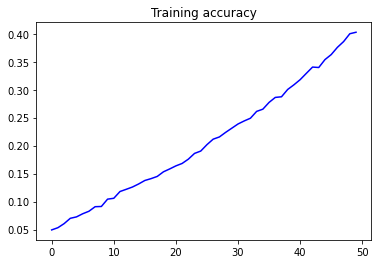

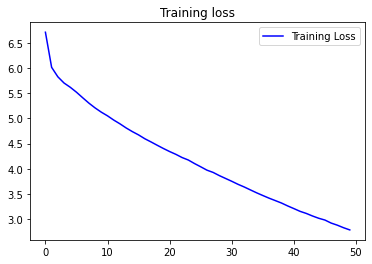

In [ ]:
# plot learning results
import matplotlib.pyplot as plt
acc = sh_model_hist.history['accuracy']
loss = sh_model_hist.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
# restore saved model 

# confirm weights file saved
print(os.listdir(checkpoint_dir))

# Create a basic model instance
restored_sh_model = create_model(embedding_size, max_seq_len-1, total_words)

# Loads the saved model weights
restored_sh_model.load_weights(checkpoint_path)

# Re-evaluate the model
#loss,acc = restored_sh_model.evaluate(test_images,  test_labels, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100*acc))

['sh_short.txt', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index', 'checkpoint']


In [ ]:
# use model to make a prediction
seed_text = "hello watson"
next_words = 20

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_seq_len - 1, padding='pre')
    predicted = restored_sh_model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

hello watson as i am in the photograph he said he i had been unlikely it lead things by a room with
